# Projet numérique: lignes de niveau
Sandra Clodion, Sophie Rossi

1ère Année Cycle Ingénieur

In [3]:
# imports
from math import *
import matplotlib.pyplot as plt
import autograd
from autograd import numpy as np
%matplotlib inline

# Contour simple

Soit $f : [0,1]^{2} \rightarrow \mathbb{R}$ une fonction $C^{1}$ et soit $c \in \mathbb{R}$.

On cherche une condition sur $f(0,0)$, $f(1,1)$ et $c$ de sorte qu'on est certain qu'il existe $t \in [0,1]$ tel que $f(0,t)=c$.

On définit $g : [0,1] \rightarrow \mathbb{R}$ par $g(t)=f(0,t)$ qui est bien $C^{1}$ et unidimensionnelle. En particulier g est continue et [0,1] est un intervalle.

D'après le théorème des fonctions intermédiaires $g([0,1])$ est un intervalle. Autrement dit:

\begin{align*}
    & \forall c \in [min(g(0),g(1),max(g(0),g(1))], \exists t \in [0,1] \text{ tel que } g(t)=c \\
    \text{ie } & \forall c \in [min(f(0,0),f(0,1),max(f(0,0),f(0,1))], \exists t \in [0,1] \text{ tel que } f(0,t)=c
\end{align*}

Il faut donc que $c$ soit entre $f(0,0)$ et $f(0,1)$.

On définit tout d'abord les fonctions auxquelles on va appliquer l'algorithme.

On pose $f : [0,1]^{2} \rightarrow \mathbb{R} $ par $f(x,y)= exp(-x^{2}-y^{2})$.

In [4]:
# definition de la fonction f
def get_f():
    def f(y,x=0.0):
        return np.exp(-x**2-y**2)
    return(f)
f=get_f()

def g(x,y):
    return np.exp(-(x-1)**2-(y-1)**2)

def h(x,y):
    return 2*(f(x,y)-g(x,y))

def grad_f(x,y):
    g=autograd.grad
    return np.r_[g(f,0)(x,y),g(f,1)(x,y)]


On construit ensuite la fonction **find_seed(f,c=0,eps=2^(-26))** qui renvoie un flottant éloigné d'au plus $eps$ de $t$ ou None si la condition n'est pas vérifiée.

Pour cela, on implémente la méthode de Newton, ce que l'on peut faire car f est $C^{1}$. Or, cette méthode trouve, si il existe, un point d'annulation de la fonction ie $t \text{ tel que } f(0,t)=0$. 

Il suffit donc de translater la fonction f de c et y appliquer la méthode de Newton. On définit donc une fonction translate_fonction (f, c) qui renvoie la fonction f transaltée de c.

Toutefois, pour pouvoir mettre en oeuvre la méthode de Newton, il faut que la dérivée de $f$ (par rapport à y) ie $g'$ ne s'annule pas sur l'intervalle $[0,1]$. Ici, $g'(t)=0 \iff t=0$ mais il suffit d'ajouter une condition d'arret de l'algorithme $\eta <=2^{-35}$. Cette condition d'arret est plus fine que celle sur $\epsilon $ ce qui assure bien que si une valeur $t$ existe, alors elle va etre trouvée avant d'avoir un problème de division par 0. 

In [5]:
def translate_fonction(f,c):
    def f_c(y,x=0):
        return f(x,y)-c
    return f_c

Enfin, on implémente une méthode de Newton: cette méthode, construit la suite définie par $xo \in [0,1]$ et $\forall n>=1,\, x_{n+1}=x_{n}- \frac{g(xn)}{g'(xn)}$.

Cette suite converge vers le point d'annulation $t$ de $g$. Mais, on ne peut etre certain que l'algorithme va converger car cela dépend de la distance entre $xo$ et $t$ qui ne doit pas etre trop grande. C'est pourquoi on pose, arbitrairement, $xo=0.5$ dans ce cas.

In [6]:
def find_seed(f,c=0,eps=2**(-26),eta=2**(-35)):
    # On récupère la dérivée
    def g(y):
        return f(0.0,y)
    dg=autograd.grad(g) 
    if c!=0:
        h=translate_fonction(f,c) # on applique la méthode de Newton à h
    else:
        h=f   
    # Vérification de la condition pour f
    if (c<min(g(0),g(1)) or c>max(g(0),g(1))):
        return None
    else:
        # Initialisation
        xn= 0.5
        fxn = h(xn)
        while (abs(fxn)>=eps and abs(dg(xn))>=eta):
            xn = xn - fxn/dg(xn) # PB DE DIVISION PAR 0!!!
            fxn=h(xn)

        return xn


In [7]:
# Par exemple:
print(f"Pour c=0.0, on obtient t={find_seed(f)}")
print(f"Pour c=0.4, on obtient t={find_seed(f,0.4)}")
print(f"Pour c=0.7, on obtient t={find_seed(f,0.7)}")

Pour c=0.0, on obtient t=None
Pour c=0.4, on obtient t=0.957230762080989
Pour c=0.7, on obtient t=0.5972226920861048


On veut maintenant coder la fonction **simple_contour** qui construit un morceau de la ligne de niveau en partant du point renvoyé par **find_seed** qui se trouve sur l'arete gauche du domaine de définition.

On définit la ligne de niveau en $c \in \mathbb{R}$ par $\mathcal{C}=\{(x,y)\in [0,1] \times [0,1] \,| \, f(x,y) = c\}$.

L'idée est alors de décrire l'allure de $\mathcal{C}$ par les tangentes en chaque point de $\mathcal{C}$. En pratique, on imposera un écart $\delta$ petit entre chaque point de la ligne.

Or, en tout point de $\mathcal{C}$, le gradient de $f$ est orthogonal à $\mathcal{C}$. Donc si on prend un vecteur unitaire orthogonal au gradient, alors celui-ci est tangent à la ligne de niveau. Les vecteurs $\vec{g}=(-\partial_{y}f(x,y),\, \partial_{x}f(x,y))$ ou $\vec{g}=(\partial_{y}f(x,y),\, -\partial_{x}f(x,y))$ conviennent (une fois renormalisés). Comme on veut que la tangente pointe vers l'intérieur du domaine, il faudra choisir le bon vecteur: c'est celui qui pointe vers les x croissants sur le repère.

Notre première idée d'algorithme consistait, à chaque itération, à faire un petit pas dans la direction de la tangente en le point. Ceci se traduit par : 
\begin{gather}
\begin{pmatrix}
 x_{i+1}\\ 
 y_{i+1}
\end{pmatrix}= 
\begin{pmatrix}
 x_{i}\\ y_{i}
\end{pmatrix}
+ \delta\times
\frac{\vec{g}}{||\vec{g}||}
\end{gather}

Ci-dessous se trouve notre implémentation:


In [8]:
def simple_contour1(f,c=0.0,delta=0.0001):
    # initialisation:
    cte=c
    x,y=[],[]
    xi,yi=0.0,find_seed(f,cte)
    xi=float(xi)
    yi=float(yi)
    x.append(xi)
    y.append(yi)
    # condition d'arret: tant qu'on ne sort pas du carré
    while 0<=xi<=1 and 0<=yi<=1:
        grad=grad_f(xi,yi)  
        direction=[grad[1],-grad[0]]
        if direction[0]<0:
            direction = [-grad[1],grad[0]]
        unitaire=direction/np.linalg.norm(direction)
        xi,yi=xi+delta*unitaire[0],yi+delta*unitaire[1]
        x.append(xi)
        y.append(yi)
    return x,y

Cet algorithme, naif, a un problème principal: à chaque pas on perd en précision et on s'éloigne toujours plus de la ligne de niveau sans meme essayer de compenser l'erreur. 

On a alors pensé à compenser une partie de ce biais en obligeant à chaque itération, de partir d'un point qui se trouve sur la ligne de niveau. Pour cela, on modifie légèrement la fonction **find_seed** en ajoutant un nouveau paramètre: le point de départ $xo$ qui vaut par défaut $0.0$.

Enfin, dans **simple_contour2**, à chaque itération, on calcule le vecteur $(x_{i+1}, y_{i+1})$ à partir de $(x_{i}, y_{i})$ où $y_{i}=find\_seed2(f,c,xi,eps)$ (et non pas le $y_{i}$ correspondant à l'itération précédente).

Ci-dessous se trouvent les codes correspondant à cette nouvelle approche:

In [9]:
def find_seed2(f, c=0.0, xo=0.0, eps=2**(-26)):
    def g(y):
        return f(xo,y)
    if c<min(g(0),g(1)) or c>max(g(0),g(1)):
        return None
    deriv_g = autograd.grad(g)
    t = 1.0
    delta = 2*eps
    while delta > eps :
        t1 = t - (g(t)-c)/deriv_g(t)
        delta = abs(t1-t)
        t = t1
    return t


In [10]:
# Par exemple:
print(f"Pour c=0.7 et xo=0.5, on obtient {find_seed2(f,c=0.7,xo=0.5)}")

Pour c=0.7 et xo=0.5, on obtient 0.3266113040584058


In [11]:
def simple_contour2(f,c=0.0,delta=0.01):
    #initialisation:
    cte=c
    abscisses,ordonnees=[],[]
    xi,yi=0.0,find_seed2(f,cte)
    xi=float(xi)
    yi=float(yi)
    abscisses.append(xi)
    ordonnees.append(yi)
# condition d'arret: tant qu'on ne sort pas du carré
    while 0<=xi<=1 and 0<=yi<=1:
        yi=find_seed2(f,cte,xi)
        grad=grad_f(xi,yi)
        direction=[grad[1],-grad[0]]
        unitaire=direction/np.linalg.norm(direction)
        xi,yi=xi+delta*unitaire[0],yi+delta*unitaire[1]
        abscisses.append(xi)
        ordonnees.append(yi)
    return x,y

Néanmoins, les résultats que l'on obtient ne sont toujours pas satisfaisants, il faut toujours que l'on s'assure que:
+ chaque $(x_{i},y_{i})$ est sur la ligne de niveau *ie*  $\forall i,\, f(x_{i},y_{i})=c$
+ les points de $C$ sont espacés de $\delta$ *ie*  $\forall i,\, (x_{i+1}-x_{i})^{2}+(y_{i+1}-y_{i})^{2}=\delta^{2}$ 

On définit alors la fonction $g_{xi,yi}$ par:

\begin{gather}
g_{xi,yi}(x,y)= 
\begin{pmatrix}
 (x_{i+1}-x_{i})^{2}+(y_{i+1}-y_{i})^{2}-\delta^{2}
 \\ f(x,y)-c
\end{pmatrix}=
\begin{pmatrix}
g_{1}(x,y)
\\g_{2}(x,y)
\end{pmatrix}
\end{gather}

On cherche alors, à chaque itération $(x_{i+1}, y_{i+1})$ tels que $g_{xi,yi}(x_{i+1}, y_{i+1})= (0, 0)$.

L'idée est alors d'implémeter une méthode de Newton en 2 dimensions qui construit la suite: 
\begin{gather}
\begin{pmatrix}
x_{n+1}
\\ y_{n+1}
\end{pmatrix}=
\begin{pmatrix}
x_{n}
\\
y_{n}
\end{pmatrix}+ \mathcal{J}_{xn,yn}^{-1} \times
\begin{pmatrix}
g_{1}(x_{n}, y_{n})\\
g_{2}(x_{n}, y_{n})
\end{pmatrix}
\end{gather}

où $\mathcal{J}_{xn,yn}^{-1}$ est l'inverse de la matrice jacobienne de $g_{x_{n},y_{n}}$.

Alors, à chaque itération, on obtiendra un point d'annulation de $g_{x_{n-1},y_{n-1}}$: ce point appartient donc à $\mathcal{C}$ et est éloigné de $\delta$ du point de $\mathcal{C}$ qui le précède.

Comme $g$ est $C^{1}$ (car ses composantes le sont) sa matrice jacobienne est bien définie en tout point. Il reste à montrer qu'elle est inversible et déterminer en quel point on l'applique.

Or, tout comme la méthode en 1D, on ne peut etre certain que l'algorithme de Newton en 2D va converger car cela dépend du point initial. 

A chaque étape de notre algorithme, on construit une nouvelle fonction $g_{x_{n},y_{n}}$ à laquelle on applique la méthode de Newton. Il faut donc définir, à chaque étape un "bon" point de départ qui ne soit pas trop éloigné du prochain point sur $\mathcal{C}$.

Pour cela, on reprend le raisonnement initial (fait pour **simple_contour1**) sur les vecteurs tangents à $\mathcal{C}$. L'idée est de déplacer le point $(x_{n}, y_{n})$ le long de la tangente de $\mathcal{C}$ en ce point en faisant un pas de $\delta$. Ce point, noté $(x_{0}, y_{0})$ est alors un bon candidat pour la convergence de la méthode de Newton. 

On a donc:
\begin{gather}
\begin{pmatrix}
 x_{0}\\ 
 y_{0}
\end{pmatrix}= 
\begin{pmatrix}
 x_{n}\\ y_{n}
\end{pmatrix}
+ \delta\times
\frac{\vec{g}}{||\vec{g}||}
\end{gather}

où $\vec{g}$ est le vecteur tangent à $\mathcal{C}$ en $(x_{n}, y_{n})$ qui pointe vers l'intérieur du carré.

On applique alors la méthode de Newton 2D à $(x_{0},y_{0})$ et à tous les points qui les succèdent. Il faut s'assurer que $\mathcal{J}_{xn,yn}$ est bien inversible en ces points. Ceci va etre le cas, du moment que ces points sont suffisamment éloignés de $(x_{n}, y_{n})$.

Par exemple, dans notre cas:
\begin{gather}
\mathcal{J}_{xn,yn}.
\begin{pmatrix}
x\\
y
\end{pmatrix}=
\begin{pmatrix}
2(x-xi)&2(y-yi)\\
-2x\exp{(-x^{2}-y^{2})} & -2y\exp{(-x^{2}-y^{2})}
\end{pmatrix}
\end{gather}


Ainsi $\mathcal{J}_{xn,yn}.(x,y) \text{ inversible } \iff |\mathcal{J}_{xn,yn}.(x,y)|\ne 0 \iff x_{n}y \ne xy_{n}$. Cette condition est toujours vérifiée car $(x_{0}, y_{0}) \ne (x_{n}, y_{n})$ et tous les autres points convergent vers $(x_{n+1}, y_{n+1})$ qui est éloigné de $\delta$ de $(x_{n}, y_{n})$.

Finalement, voici notre algorithme **simple_contour**:

In [12]:
def simple_contour(f,c=0.0,delta=0.01):
    
    cte=c
    #initialisation
    abscisses,ordonnees=[],[]
    
    #initialisation: seed nous donne le premier point de la courbe de niveau à partir duquel on va construire tous les autres
    xi,yi=0.0,find_seed(f,cte)
    if yi==None:
        return abscisses, ordonnees
    xi=float(xi)
    yi=float(yi)
    abscisses.append(xi)
    ordonnees.append(yi)
    #ici, xi,yi est la graine
    
    def G(x,y):
        g1=(xi-x)**2+(yi-y)**2-delta**2
        g2=f(x,y)-c
        return np.array([g1,g2])
    
    def J_G(x,y):
        j=autograd.jacobian
        return np.c_[j(G,0)(x,y),j(G,1)(x,y)]

    grad=grad_f(xi,yi)
    direction=[grad[1],-grad[0]]
    if direction[0]<0:
        direction = [-grad[1],grad[0]]
    direction_memoire=direction
    nb_iter=0
    while nb_iter<1000 and 0<=xi<=1 and 0<=yi<=1: 
        #on impose un nombre maximum d'itérations au cas où on ait une ligne de niveau qui boucle
        #on implemente newton en 2D: mais on veut etre suffisamment proches du prochain point de la ligne de niveau
        # pour etre surs au'il converge --> tangente nous donne le point d'initialisation de newton
        nb_iter+=1
        grad=grad_f(xi,yi)
        direction=[grad[1],-grad[0]]
        if ((direction_memoire[0]*direction[0]+direction_memoire[1]*direction[1])<0):
            direction=[-grad[1],grad[0]]
        #if direction[0]<0:
            #direction = [-grad[1],grad[0]]
        unitaire=direction/np.linalg.norm(direction)
        xo,yo=xi+delta*unitaire[0],yi+delta*unitaire[1]
        #xo,yo est le point de départ de la méthode de Newton (celui trouvé avec la tangente)
    
        X=np.array([xo,yo])
        
        distance = 2
        xn,yn = X[0],X[1]
        while (distance>2**(-26) and abs(np.linalg.det(J_G(X[0],X[1])))>2**(-26)):
            xn,yn = X[0],X[1]
            Jinv = np.linalg.inv(J_G(xn,yn))
            X1=X-Jinv.dot(G(xn,yn))
            distance=np.linalg.norm(X1-X)
            X=X1
        
        xi,yi = X[0],X[1] #xi,yi est le point suivant de la ligne de niveau
        abscisses.append(xi)
        ordonnees.append(yi)
        direction_memoire=direction
    return abscisses, ordonnees

In [13]:
#Par exemple:
x,y=simple_contour(f,c=0.7)
print(x)
print(y)
#on prend la dernière valeur de chaque liste 
#et on vérifie que le couple x,y correspondant a bien pour image 0.7 par la fonction f

print(f"\n f(0.5972196832032609,-0.0018957672138471295)={f(0.5972196832032609, -0.0018957672138471295)}")

[0.0, 0.00999964953467527, 0.019996495494384443, 0.02998773509013836, 0.03997056710481608, 0.04994219267850767, 0.059899816093223084, 0.06984064555672011, 0.07976189398523179, 0.08966077978487345, 0.09953452763151101, 0.10938036924887087, 0.11919554418467444, 0.12897730058457849, 0.13872289596370538, 0.14842959797554617, 0.1580946851780212, 0.16771544779648362, 0.17728918848345163, 0.18681322307485665, 0.1962848813425951, 0.20570150774317325, 0.21506046216223468, 0.22435912065476213, 0.2335948761807461, 0.2427651393361135, 0.25186733907871206, 0.26089892344914645, 0.26985736028626434, 0.27874013793709174, 0.2875447659610182, 0.2962687758280353, 0.30490972161083146, 0.31346518067055046, 0.32193275433601964, 0.33031006857625955, 0.33859477466608434, 0.3467845498446072, 0.3548770979664675, 0.3628701501455942, 0.37076146539132765, 0.37854883123671984, 0.38623006435883855, 0.39380301119089894, 0.40126554852605373, 0.4086155841126711, 0.4158510572409334, 0.4229699393205932, 0.429970234449723

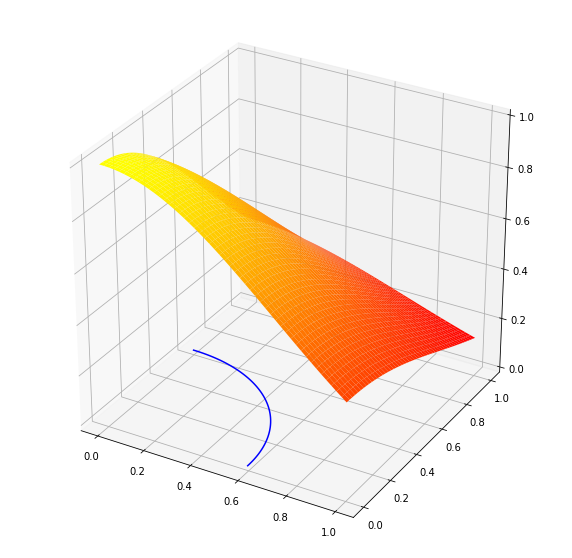

<Figure size 432x288 with 0 Axes>

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

def ff(x,y):
    return np.exp(-x**2-y**2)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
domain_x = np.linspace(0, 1)   
domain_y = np.linspace(0, 1)
# création de la grille
X, Y = np.meshgrid(domain_x, domain_y)
# calcul de z=f(x,y) pour chacun des couples (x,y) dans [0,1]^2
Z = ff(X, Y)
fig = plt.figure()
# on plotte la figure en 3D
ax.plot_surface(X, Y, Z, cmap='autumn')
ax.plot(x,y,color="blue") #on visualise la coube de niveau sur le plan Oxy

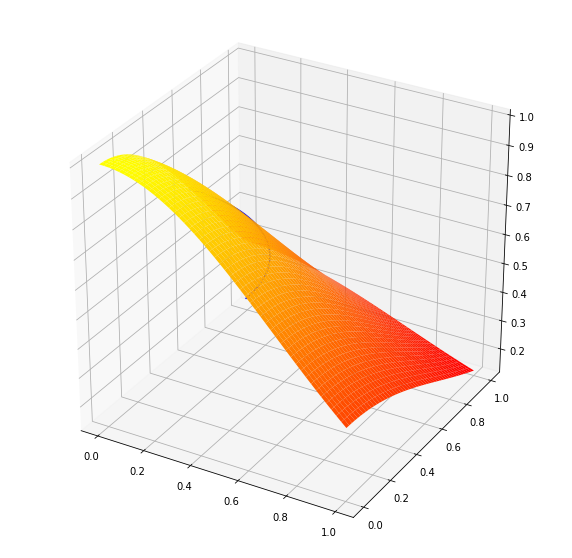

<Figure size 432x288 with 0 Axes>

In [15]:
# ou bien on peut tracer la coube de niveau à sa bonne hauteur (c)
from mpl_toolkits.mplot3d import Axes3D

def ff(x,y):
    return np.exp(-x**2-y**2)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
domain_x = np.linspace(0, 1)   
domain_y = np.linspace(0, 1)
# création de la grille
X, Y = np.meshgrid(domain_x, domain_y)
# calcul de z=f(x,y) pour chacun des couples (x,y) dans [0,1]^2
Z = ff(X, Y)
fig = plt.figure()
# on plotte la figure en 3D
z=[]
for i in range(len(x)):
    z.append(0.7)
    
ax.plot(x,y,z,color="blue") #on met la courbe de niveau à la bonne hauteur

ax.plot_surface(X, Y, Z, cmap='autumn')


#ca rend l'idée ... plus ou moins

# Contour complexe

On considère maintenant $f$ sur un domaine quelconque: $f:[a,b] \times [c,d] \rightarrow \mathbb{R}$ où $a, b, c, d \in \mathbb{R}$

In [16]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta) #PB: matrice J n'est pas inv
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves

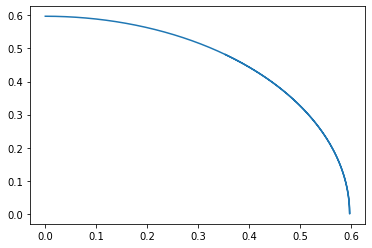

In [17]:
#Pour c=0.7 sur [0,1]^2
curves = contour(f,0.7)
abscisses=[]
ordonnees=[]
for el in curves:
    a,o=el[0],el[1]
    aa=a.tolist()
    if len(aa)>0:
        aa.pop() #on enlève le dernier point de chaque liste car c'est un point aberrant qui fausse tout le reste!
    bb=o.tolist()
    if len(aa)>0:
        bb.pop()
    abscisses.extend(aa)
    ordonnees.extend(bb)
plt.plot(abscisses,ordonnees)

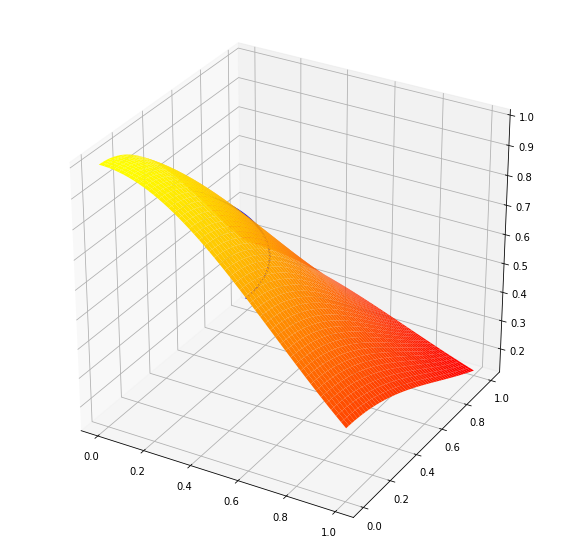

<Figure size 432x288 with 0 Axes>

In [18]:
domain_x = np.linspace(0.0, 1.0)   
domain_y = np.linspace(0.0, 1.0)
# création de la grille
X, Y = np.meshgrid(domain_x, domain_y)
# calcul de z=f(x,y) pour chacun des couples (x,y) dans [0,1]^2
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
Z = ff(X, Y)
fig = plt.figure()
# on plotte la figure en 3D
z=[]
for i in range(len(abscisses)):
    z.append(0.7)

ax.plot_surface(X, Y, Z, cmap='autumn')
ax.plot(abscisses,ordonnees,z, color="blue")

#ON RETROUVE LA MEME COURBE QU'AVEC SIMPLE_CONTOUR!

True


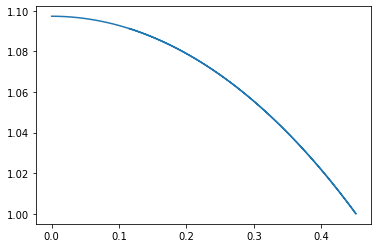

In [19]:
curves = contour(f,0.3, [0.0,1.0], [1.0,2.0])
abscisses=[]
ordonnees=[]
for el in curves:
    a,o=el[0],el[1]
    aa=a.tolist()
    if len(aa)>0:
        aa.pop() #on enlève le dernier point de chaque liste car c'est un point aberrant qui fausse tout le reste!
    bb=o.tolist()
    if len(aa)>0:
        bb.pop()
    abscisses.extend(aa)
    ordonnees.extend(bb)
print(len(abscisses)==len(ordonnees))
plt.plot(abscisses,ordonnees)

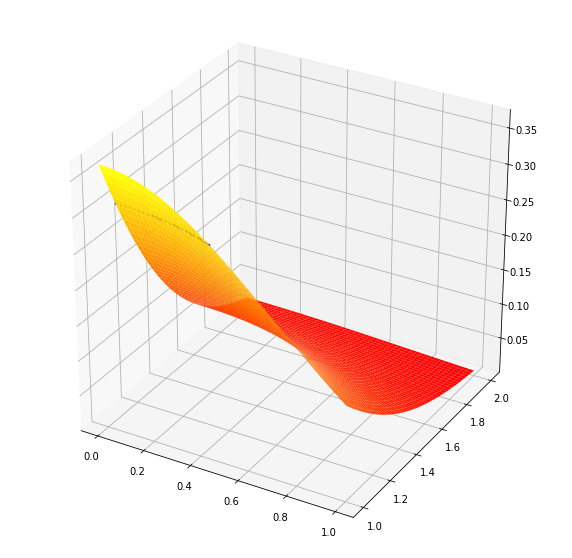

<Figure size 432x288 with 0 Axes>

In [20]:
domain_x = np.linspace(0.0, 1.0)   
domain_y = np.linspace(1.0, 2.0)
# création de la grille
X, Y = np.meshgrid(domain_x, domain_y)
# calcul de z=f(x,y) pour chacun des couples (x,y) dans [0,1]^2
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
Z = ff(X, Y)
fig = plt.figure()
# on plotte la figure en 3D
z=[]
for i in range(len(abscisses)):
    z.append(0.3)
ax.plot_surface(X, Y, Z, cmap='autumn')
ax.plot(abscisses,ordonnees,z, color="blue")

True


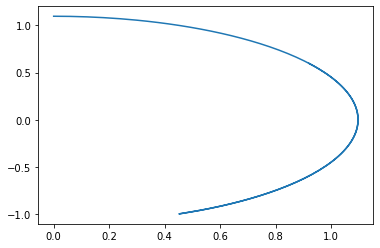

In [21]:
curves = contour(f,0.3, [0.0,2.0], [-1.0,2.0])
abscisses=[]
ordonnees=[]
for el in curves:
    a,o=el[0],el[1]
    aa=a.tolist()
    if len(aa)>0:
        aa.pop() #on enlève le dernier point de chaque liste car c'est un point aberrant qui fausse tout le reste!
    bb=o.tolist()
    if len(aa)>0:
        bb.pop()
    while len(aa)>len(bb):
        aa.pop()
    while len(bb)>len(aa):
        bb.pop()
    
    abscisses.extend(aa)
    ordonnees.extend(bb)
print(len(abscisses)==len(ordonnees))
plt.plot(abscisses,ordonnees)


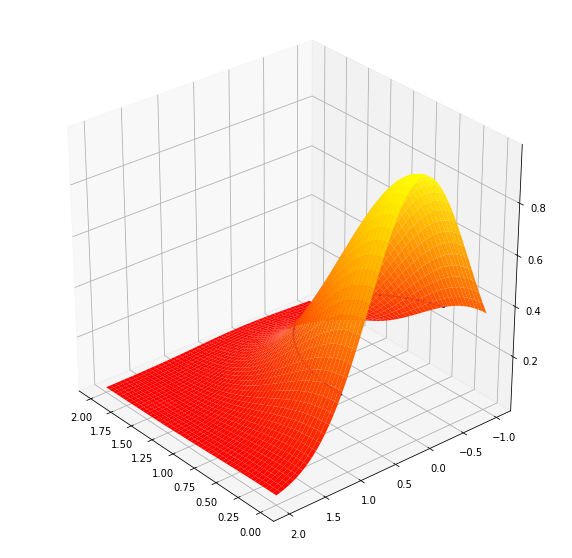

<Figure size 432x288 with 0 Axes>

In [22]:
domain_x = np.linspace(0.0, 2.0)   
domain_y = np.linspace(-1.0, 2.0)
# création de la grille
X, Y = np.meshgrid(domain_x, domain_y)
# calcul de z=f(x,y) pour chacun des couples (x,y) dans [0,1]^2
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
Z = ff(X, Y)
fig = plt.figure()
# on plotte la figure en 3D
z=[]
for i in range(len(abscisses)):
    z.append(0.3)
ax.plot_surface(X, Y, Z, cmap='autumn')
ax.plot(abscisses,ordonnees,z, color="blue")
ax.view_init(30,140) #pour tourner la figure


True


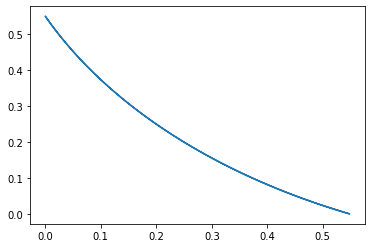

In [23]:
curves = contour(g,0.3, [0.0,1.0], [0.0,1.0])
abscisses=[]
ordonnees=[]
for el in curves:
    a,o=el[0],el[1]
    aa=a.tolist()
    if len(aa)>0:
        aa.pop() #on enlève le dernier point de chaque liste car c'est un point aberrant qui fausse tout le reste!
    bb=o.tolist()
    if len(aa)>0:
        bb.pop()
    abscisses.extend(aa)
    ordonnees.extend(bb)
print(len(abscisses)==len(ordonnees))
plt.plot(abscisses,ordonnees)

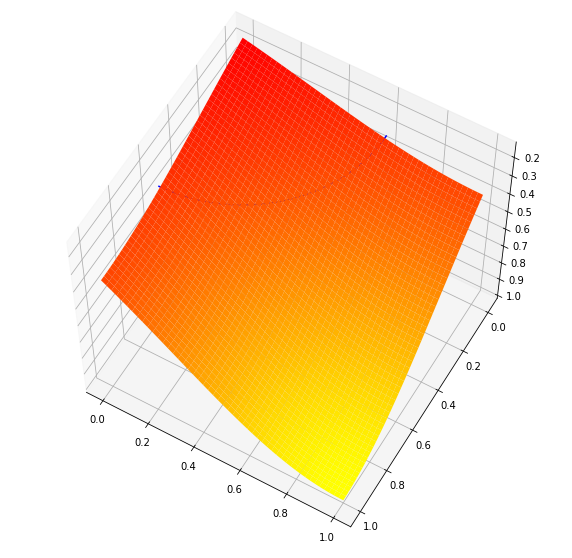

<Figure size 432x288 with 0 Axes>

In [24]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
domain_x = np.linspace(0, 1)   
domain_y = np.linspace(0, 1)
# création de la grille
X, Y = np.meshgrid(domain_x, domain_y)
# calcul de z=f(x,y) pour chacun des couples (x,y) dans [0,1]^2
Z = g(X, Y)
fig = plt.figure()
# on plotte la figure en 3D
z=[]
for i in range(len(x)):
    z.append(0.3)
    
ax.plot(x,y,z,color="blue") #on met la courbe de niveau à la bonne hauteur

ax.plot_surface(X, Y, Z, cmap='autumn')
ax.view_init(240,240)